## Imports

In [1]:
import os
import csv
import tqdm
import torch
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
import seaborn as sns
import torchmetrics as tm
from torchmetrics import Dice
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from torchmetrics.aggregation import MeanMetric
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

c:\Users\Ayeezh\miniconda3\envs\ef_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

Load a random sample from dataset.

<class 'numpy.ndarray'>
(549, 389)
(549, 389)


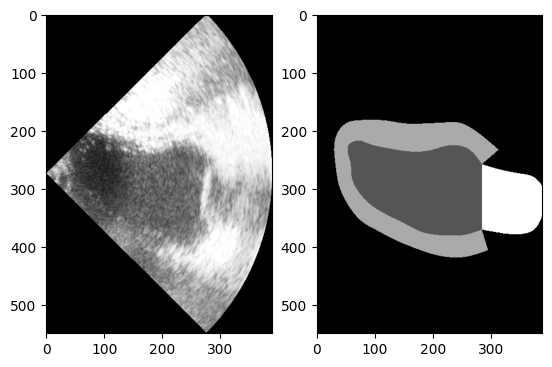

In [157]:
image_path = './database_nifti/patient0001/patient0001_2CH_ED.nii.gz'
image_seg = './database_nifti/patient0001/patient0001_2CH_ED_gt.nii.gz'
img = nib.load(image_path)
seg = nib.load(image_seg)
data = img.get_fdata()
label = seg.get_fdata()
print(type(data))
print(data.shape)
print(label.shape)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(data, cmap='grey')
axes[1].imshow(label, cmap='grey')

The dataset are too heavy and we can't load all the dataset immediately. so we have to make a csv file from dataset and use data_loader to load the dataset in batches.


In [3]:
def make_csv(root, output_csv='output.csv'):
    patients = os.listdir(root) 
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Patient', 'ED', 'ES', 'NbFrame', 'Sex', 'Age', 'ImageQuality', 'EF', 'FrameRate'])
        
        for patient in patients:
            patient_dir = os.path.join(root, patient) 
            if os.path.isdir(patient_dir): 
                cfg_file = os.path.join(patient_dir, 'Info_2CH.cfg')
                if os.path.isfile(cfg_file):
                    config = {}
                    with open(cfg_file, 'r') as file:
                        for line in file:
                            key, value = line.strip().split(':', 1)
                            config[key.strip()] = value.strip()
                    
                    writer.writerow([
                        patient,
                        config.get('ED', ''),
                        config.get('ES', ''),
                        config.get('NbFrame', ''),
                        config.get('Sex', ''),
                        config.get('Age', ''),
                        config.get('ImageQuality', ''),
                        config.get('EF', ''),
                        config.get('FrameRate', '')
                    ])
                else:
                    print(f"{patient} information not found!")
            else:
                print(f"{patient} is not a directory!")

make_csv('./database_nifti', output_csv='patients_info.csv')

In [4]:
df = pd.read_csv('patients_info.csv')
df

,Patient,ED,ES,NbFrame,Sex,Age,ImageQuality,EF,FrameRate
0,patient0001,1,18,18,F,56,Good,54,48.4
1,patient0002,1,17,17,M,55,Medium,40,50.5
2,patient0003,1,17,17,F,36,Good,51,56.5
3,patient0004,1,19,19,F,79,Good,56,48.4
4,patient0005,1,20,20,F,78,Medium,48,56.5
...,...,...,...,...,...,...,...,...,...
495,patient0496,1,21,21,F,86,Medium,50,55.4
496,patient0497,1,24,24,M,74,Good,61,55.4
497,patient0498,1,18,18,M,68,Poor,71,55.4
498,patient0499,1,16,16,F,75,Medium,65,53.1


### EDA

In [126]:
# Statistical information from the dataset
df.describe()

,ED,ES,NbFrame,Age,EF,FrameRate
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.060000,18.476000,18.536000,65.080000,44.226000,55.622200
std,0.999198,3.495979,3.334508,14.380096,12.006133,4.471093
min,1.000000,1.000000,10.000000,18.000000,4.000000,32.600000
25%,1.000000,16.000000,16.000000,55.750000,37.000000,55.300000
50%,1.000000,18.000000,18.000000,67.000000,45.000000,56.500000
75%,1.000000,20.000000,20.000000,76.000000,52.000000,56.500000
max,21.000000,32.000000,32.000000,93.000000,81.000000,85.500000


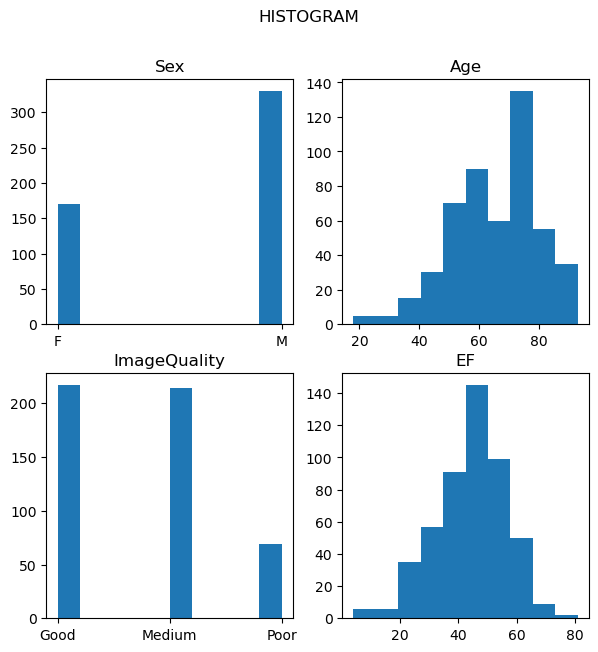

In [127]:
# Creating histograms for selected columns to analyze the distribution of data

columns_to_plot_histogram = ['Sex', 'Age', 'ImageQuality', 'EF']

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 7))
axes_flatten = axes.flatten()
fig.suptitle('HISTOGRAM')

for i, col in enumerate(columns_to_plot_histogram):
    ax = axes_flatten[i]
    ax.hist(df[col])
    ax.set_title(col)

<Axes: >

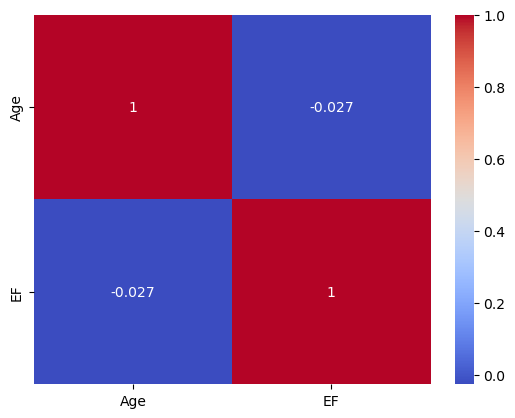

In [129]:
# Creating a heatmap to visualize the correlation matrix of Age and EF
correlation_matrix = df[['Age', 'EF']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

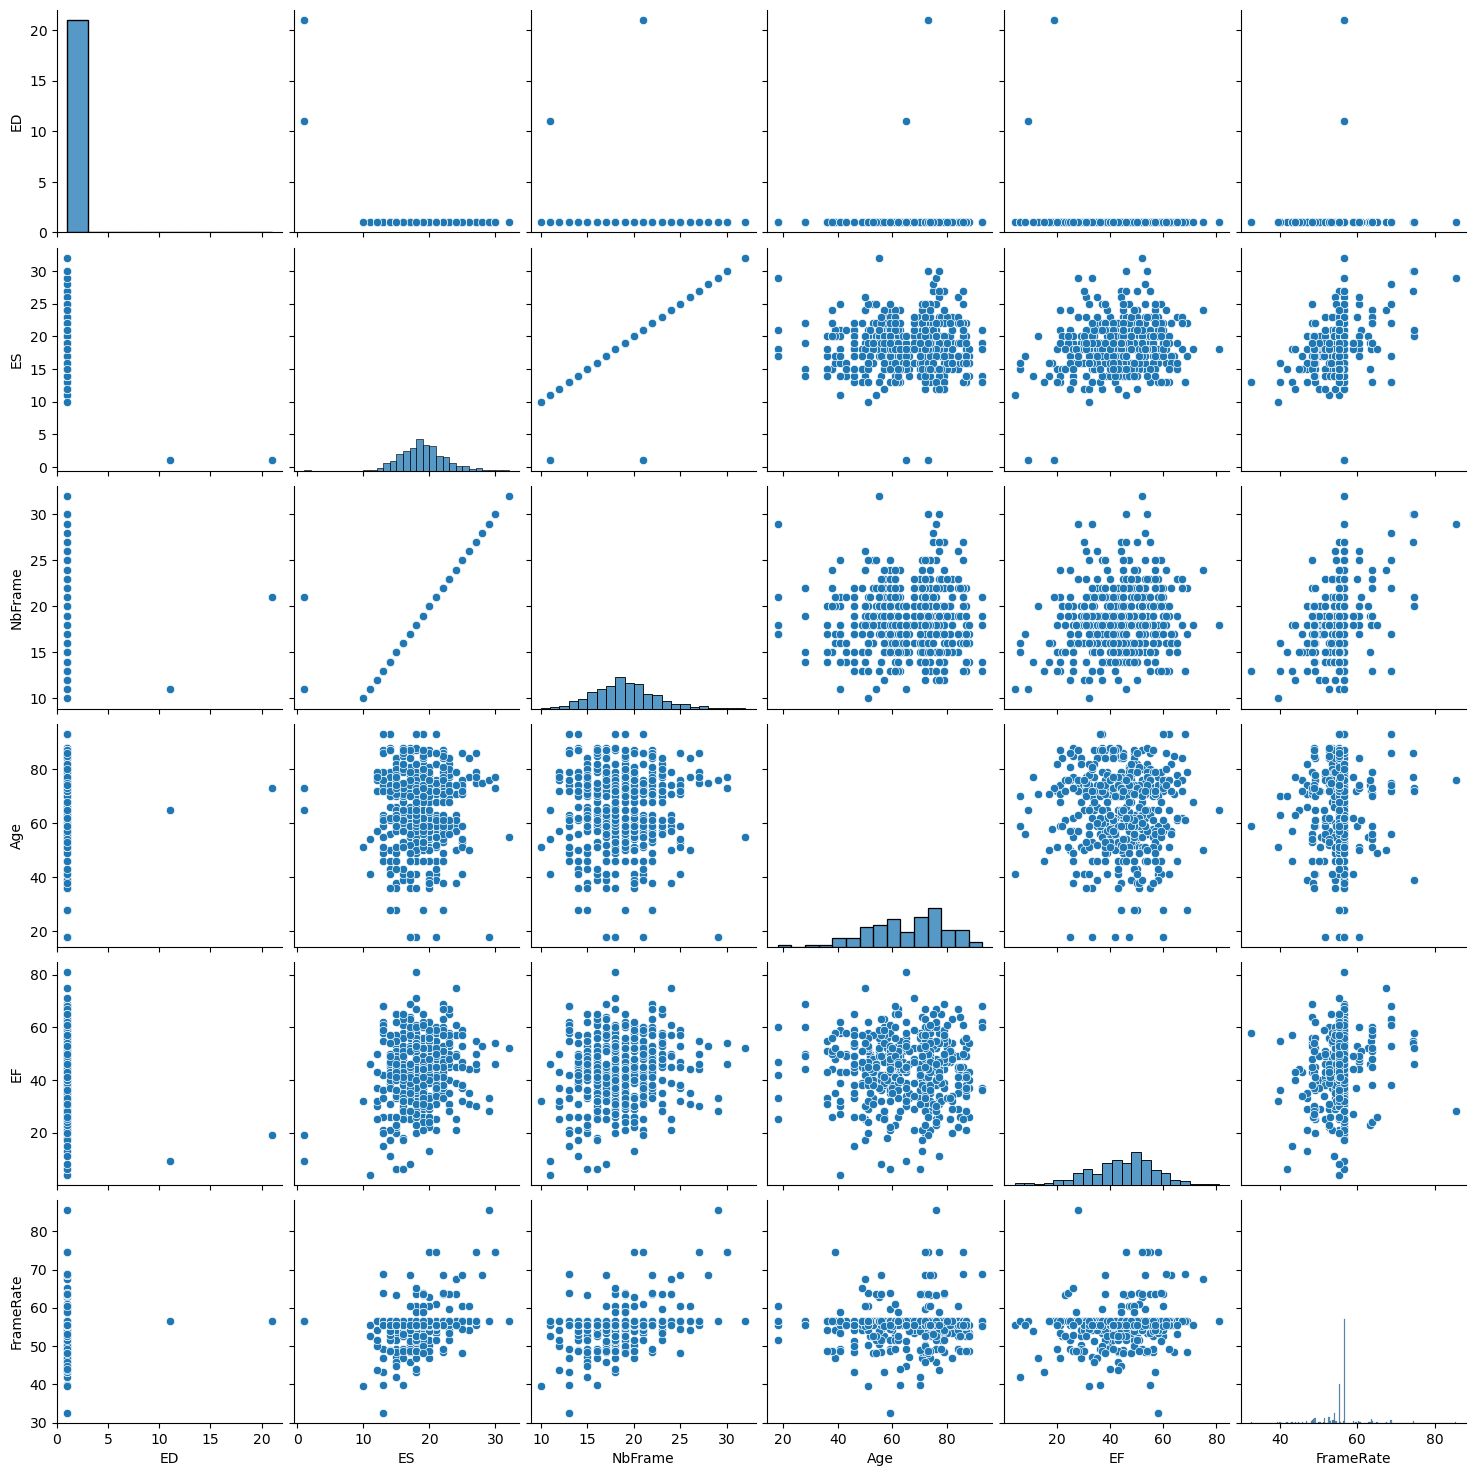

In [130]:
# Generating a pairplot to explore relationships between all numerical features and identify potential correlations.
sns.pairplot(df)

### Train Test Split

We should split the dataset to train, test and validation to use them in training process.

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test, df_valid = train_test_split(df_test, test_size=0.5, random_state=42)

df_train.to_csv('./train_set.csv', index=False)
df_valid.to_csv('./valid_set.csv', index=False)
df_test.to_csv('./test_set.csv', index=False)

### Custom Dataset

In [6]:
class CamusDataset(Dataset):
    def __init__(self, root = None, csv_file = None, transform = None, target_transform = None):
        super().__init__()

        self.root = root
        self.csv_file = csv_file
        self.transform = transform
        self.target_transform = target_transform
        self.data = pd.read_csv(self.csv_file)
    
    def __getitem__(self, index):
        patient = self.data.iloc[index, 0]
        
        ed2_img = nib.load(f'{self.root}/{patient}/{patient}_2CH_ED.nii.gz').get_fdata()
        es2_img = nib.load(f'{self.root}/{patient}/{patient}_2CH_ES.nii.gz').get_fdata()

        ed2_seg = nib.load(f'{self.root}/{patient}/{patient}_2CH_ED_gt.nii.gz').get_fdata()
        es2_seg = nib.load(f'{self.root}/{patient}/{patient}_2CH_ES_gt.nii.gz').get_fdata()

        ed4_img = nib.load(f'{self.root}/{patient}/{patient}_4CH_ED.nii.gz').get_fdata()
        es4_img = nib.load(f'{self.root}/{patient}/{patient}_4CH_ES.nii.gz').get_fdata()

        ed4_seg = nib.load(f'{self.root}/{patient}/{patient}_4CH_ED_gt.nii.gz').get_fdata()
        es4_seg = nib.load(f'{self.root}/{patient}/{patient}_4CH_ES_gt.nii.gz').get_fdata()

        if self.transform:
            ed2_img = self.transform(ed2_img)
            es2_img = self.transform(es2_img)
            ed4_img = self.transform(ed4_img)
            es4_img = self.transform(es4_img)
        
        if self.target_transform:
            ed2_seg = self.target_transform(ed2_seg)
            es2_seg = self.target_transform(es2_seg)
            ed4_seg = self.target_transform(ed4_seg)
            es4_seg = self.target_transform(es4_seg)
        
        return ed2_img, es2_img, ed4_img, es4_img, ed2_seg, es2_seg, ed4_seg, es4_seg
    
    def __len__(self):
        return len(self.data)

In [7]:
def resize_mask(mask, size=(224, 224)):
    mask = torch.tensor(mask, dtype=torch.float32)
    mask = mask.unsqueeze(0).unsqueeze(0)
    mask_resized = F.interpolate(mask, size=size, mode='nearest') 
    return mask_resized.squeeze(0).long() 

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
])

target_transform = T.Compose([
    T.Lambda(lambda x: resize_mask(x, size=(224, 224)))
])

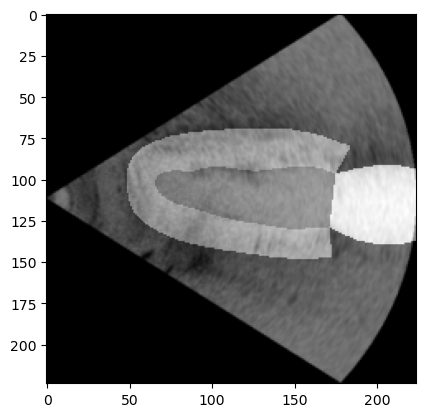

In [133]:
camus = CamusDataset(root='./database_nifti', 
                     transform=transform, 
                     target_transform=target_transform, 
                     csv_file='train_set.csv')
ed2_img, es2_img, ed4_img, es4_img, ed2_seg, es2_seg, ed4_seg, es4_seg = camus[110]
plt.imshow(es2_img[0], cmap='gray')
plt.imshow(es2_seg[0], alpha=0.5, cmap='gray')

In [8]:
train_set = CamusDataset(root='./database_nifti',
 transform=transform,
 target_transform=target_transform,
 csv_file='train_set.csv')
valid_set = CamusDataset(root='./database_nifti',
 transform=transform,
 target_transform=target_transform,
 csv_file='valid_set.csv')
test_set = CamusDataset(root='./database_nifti',
 transform=transform,
 target_transform=target_transform,
 csv_file='test_set.csv')

### DataLoader

In [9]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

In [136]:
ed2_img, es2_img, ed4_img, es4_img, ed2_seg, es2_seg, ed4_seg, es4_seg = next(iter(train_loader))
ed2_img.shape, es2_img.shape, ed4_img.shape, es4_img.shape, ed2_seg.shape, es2_seg.shape, ed4_seg.shape, es4_seg.shape

(torch.Size([8, 1, 224, 224]),
 torch.Size([8, 1, 224, 224]),
 torch.Size([8, 1, 224, 224]),
 torch.Size([8, 1, 224, 224]),
 torch.Size([8, 1, 224, 224]),
 torch.Size([8, 1, 224, 224]),
 torch.Size([8, 1, 224, 224]),
 torch.Size([8, 1, 224, 224]))

In [137]:
len(train_loader), len(valid_loader), len(test_loader)

(50, 7, 7)

## Model

In [138]:
unet = smp.Unet(encoder_name='efficientnet-b1', encoder_weights='imagenet', 
                in_channels=1, classes=4)
unet

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

## Config

In [142]:
loss_fn = smp.losses.DiceLoss(mode='multiclass')
metric = Dice(num_classes=4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(encoder_name='efficientnet-b1', encoder_weights='imagenet', 
                in_channels=1, classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train

In [146]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):

  model.train()
  loss_train = MeanMetric()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for ed2_img, es2_img, ed4_img, es4_img, ed2_seg, es2_seg, ed4_seg, es4_seg in tepoch:

      ed2_img = ed2_img.to(device)
      es2_img = es2_img.to(device)
      ed4_img = ed4_img.to(device)
      es4_img = es4_img.to(device)

      ed2_seg = ed2_seg.to(device)
      es2_seg = es2_seg.to(device)
      ed4_seg = ed4_seg.to(device)
      es4_seg = es4_seg.to(device)

      
      tepoch.set_description(f'Epoch {epoch}')

      ed2_pred = model(ed2_img)
      es2_pred = model(es2_img)
      ed4_pred = model(ed4_img)
      es4_pred = model(es4_img)


      loss_ed2 = loss_fn(ed2_pred, ed2_seg)
      loss_es2 = loss_fn(es2_pred, es2_seg)
      loss_ed4 = loss_fn(ed4_pred, ed4_seg)
      loss_es4 = loss_fn(es4_pred, es4_seg)
      loss = (loss_ed2 + loss_es2 + loss_ed4 + loss_es4) / 4
      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), weight=len(ed2_seg))
      metric.update(ed2_pred, ed2_seg)
      metric.update(es2_pred, es2_seg)
      metric.update(ed4_pred, ed4_seg)
      metric.update(es4_pred, es4_seg)
      tepoch.set_postfix(loss=loss_train.compute().item(), metric=metric.compute().item())

  return model, loss_train.compute().item(), metric.compute().item()

In [147]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = MeanMetric()
  metric.reset()

  with torch.no_grad():
    for ed2_img, es2_img, ed4_img, es4_img, ed2_seg, es2_seg, ed4_seg, es4_seg in test_loader:

      ed2_img = ed2_img.to(device)
      es2_img = es2_img.to(device)
      ed4_img = ed4_img.to(device)
      es4_img = es4_img.to(device)

      ed2_pred = model(ed2_img)
      es2_pred = model(es2_img)
      ed4_pred = model(ed4_img)
      es4_pred = model(es4_img)

      loss_ed2 = loss_fn(ed2_pred, ed2_seg)
      loss_es2 = loss_fn(es2_pred, es2_seg)
      loss_ed4 = loss_fn(ed4_pred, ed4_seg)
      loss_es4 = loss_fn(es4_pred, es4_seg)
      loss = (loss_ed2 + loss_es2 + loss_ed4 + loss_es4) / 4
      loss_eval.update(loss.item(), weight=len(es2_seg))
      metric.update(ed2_pred, ed2_seg)
      metric.update(es2_pred, es2_seg)
      metric.update(ed4_pred, ed4_seg)
      metric.update(es4_pred, es4_seg)

  return loss_eval.compute().item(), metric.compute().item()

compute the loss for a few batches to see how much it costs around and check the forward path.


In [22]:
i = 5
for ed2_img, es2_img, ed4_img, es4_img, ed2_seg, es2_seg, ed4_seg, es4_seg in  train_loader:
  if i == 0:   
    break
  i -= 1
  with torch.no_grad():
    ed2_pred = model(ed2_img)
    es2_pred = model(es2_img)
    ed4_pred = model(ed4_img)
    es4_pred = model(es4_img)

    loss_ed2 = loss_fn(ed2_pred, ed2_seg)
    loss_es2 = loss_fn(es2_pred, es2_seg)
    loss_ed4 = loss_fn(ed4_pred, ed4_seg)
    loss_es4 = loss_fn(es4_pred, es4_seg)
    loss = (loss_ed2 + loss_es2 + loss_ed4 + loss_es4) / 4
    print(f'loss: {loss}')

loss: 0.8158116340637207
loss: 0.8238059282302856
loss: 0.81284499168396
loss: 0.8288991451263428
loss: 0.8149268627166748


Creating a mini_dataset and try to overfit it to check the backward path.


In [143]:
mini_dataset, _ = random_split(train_set, [len(train_set)-300, 300])
mini_loader = DataLoader(mini_dataset, 8, True)

In [144]:
len(mini_loader)

13

In [148]:
n_epochs = 10

for epoch in range(n_epochs):
  model, _, _ = train_one_epoch(model,
                                mini_loader,
                                loss_fn,
                                optimizer,
                                metric,
                                epoch)

Epoch 9: 100%|██████████| 13/13 [01:19<00:00,  6.15s/batch, loss=0.0677, metric=0.968]


Testing and selecting the best lr for optimizer.


In [313]:
num_epochs = 3

for lr in [0.3, 0.1, 0.01, 0.001]:
    print(f'LR = {lr}')

    model = smp.Unet(encoder_name='efficientnet-b   1', encoder_weights='imagenet', 
                in_channels=1, classes=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)
    
    print()

LR = 0.3


Epoch 2: 100%|██████████| 50/50 [02:50<00:00,  3.40s/batch, loss=0.272, metric=0.887]



LR = 0.1


Epoch 2: 100%|██████████| 50/50 [03:22<00:00,  4.05s/batch, loss=0.191, metric=0.91] 



LR = 0.01


Epoch 2: 100%|██████████| 50/50 [02:38<00:00,  3.18s/batch, loss=0.122, metric=0.94] 



LR = 0.001


Epoch 2: 100%|██████████| 50/50 [02:36<00:00,  3.14s/batch, loss=0.0917, metric=0.957]

The main training loop.

In [315]:
model = smp.Unet(encoder_name='efficientnet-b1', encoder_weights='imagenet', 
                in_channels=1, classes=4).to(device)

In [149]:
Acc_train_hist = []
Acc_valid_hist = []
loss_train_hist = []
loss_valid_hist = []

best_loss = np.inf

In [153]:
loss_fn = smp.losses.DiceLoss(mode='multiclass')
metric = Dice(num_classes=4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [154]:
num_epochs = 10

for epoch in range(num_epochs):

  model, loss_train, Acc_train = train_one_epoch(model,
                                  train_loader,
                                  loss_fn,
                                  optimizer,
                                  metric,
                                  epoch)
  Acc_train_hist.append(Acc_train)
  loss_train_hist.append(loss_train)

  loss_valid, Acc_valid = evaluate(model, valid_loader, loss_fn, metric)

  Acc_valid_hist.append(Acc_valid)
  loss_valid_hist.append(loss_valid)

  print(f'Acc_valid: {Acc_valid:.4}')
  print(f'loss_valid: {loss_valid:.4}')

  if loss_valid < best_loss:
    best_loss = loss_valid
    torch.save(model, 'unet.pt')
    print('model saved!')

Epoch 0: 100%|██████████| 50/50 [05:20<00:00,  6.40s/batch, loss=0.0527, metric=0.975]


Acc_valid: 0.9643
loss_valid: 0.07728
model saved!


Epoch 1: 100%|██████████| 50/50 [05:10<00:00,  6.20s/batch, loss=0.0514, metric=0.976]


Acc_valid: 0.9644
loss_valid: 0.0773


Epoch 2: 100%|██████████| 50/50 [05:20<00:00,  6.42s/batch, loss=0.0519, metric=0.976]


Acc_valid: 0.9644
loss_valid: 0.0774


Epoch 3: 100%|██████████| 50/50 [05:18<00:00,  6.36s/batch, loss=0.052, metric=0.976] 


Acc_valid: 0.9643
loss_valid: 0.07753


Epoch 4: 100%|██████████| 50/50 [05:16<00:00,  6.32s/batch, loss=0.0512, metric=0.976]


Acc_valid: 0.9644
loss_valid: 0.07726
model saved!


Epoch 5: 100%|██████████| 50/50 [05:17<00:00,  6.36s/batch, loss=0.0513, metric=0.976]


Acc_valid: 0.9643
loss_valid: 0.07785


Epoch 6: 100%|██████████| 50/50 [05:05<00:00,  6.11s/batch, loss=0.0505, metric=0.976]


Acc_valid: 0.9644
loss_valid: 0.07713
model saved!


Epoch 7: 100%|██████████| 50/50 [05:36<00:00,  6.73s/batch, loss=0.0503, metric=0.976]


Acc_valid: 0.9644
loss_valid: 0.07721


Epoch 8: 100%|██████████| 50/50 [05:32<00:00,  6.66s/batch, loss=0.0503, metric=0.977]


Acc_valid: 0.9644
loss_valid: 0.07732


Epoch 9: 100%|██████████| 50/50 [05:31<00:00,  6.62s/batch, loss=0.0505, metric=0.976]


Acc_valid: 0.9643
loss_valid: 0.0773


Ploting the Dice metric and loss.


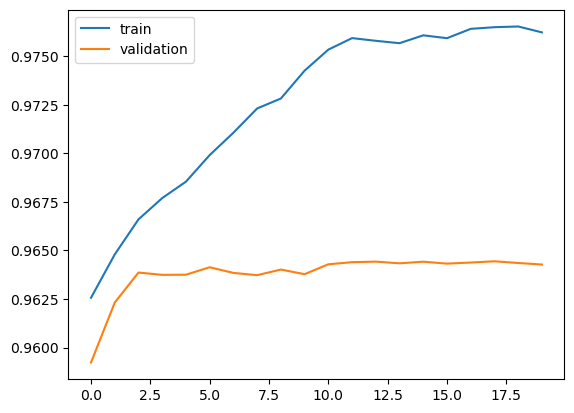

In [171]:
plt.plot(Acc_train_hist, label='train')
plt.plot(Acc_valid_hist, label='validation')
plt.legend()

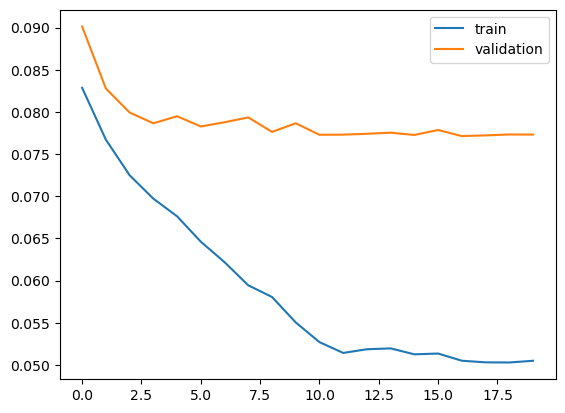

In [173]:
plt.plot(loss_train_hist, label='train')
plt.plot(loss_valid_hist, label='validation')
plt.legend()

## Test


Load the best model.

In [18]:
model = torch.load('unet.pt')
model

C:\Users\Ayeezh\AppData\Local\Temp\ipykernel_6496\2722045266.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('unet.pt')


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

Testing the model.


In [13]:
ed2_img, es2_img, ed4_img, es4_img, ed2_seg, es2_seg, ed4_seg, es4_seg = next(iter(test_loader))

with torch.no_grad():
    ed2_pred = model(ed2_img)
    es2_pred = model(es2_img)
    ed4_pred = model(ed4_img)
    es4_pred = model(es4_img)

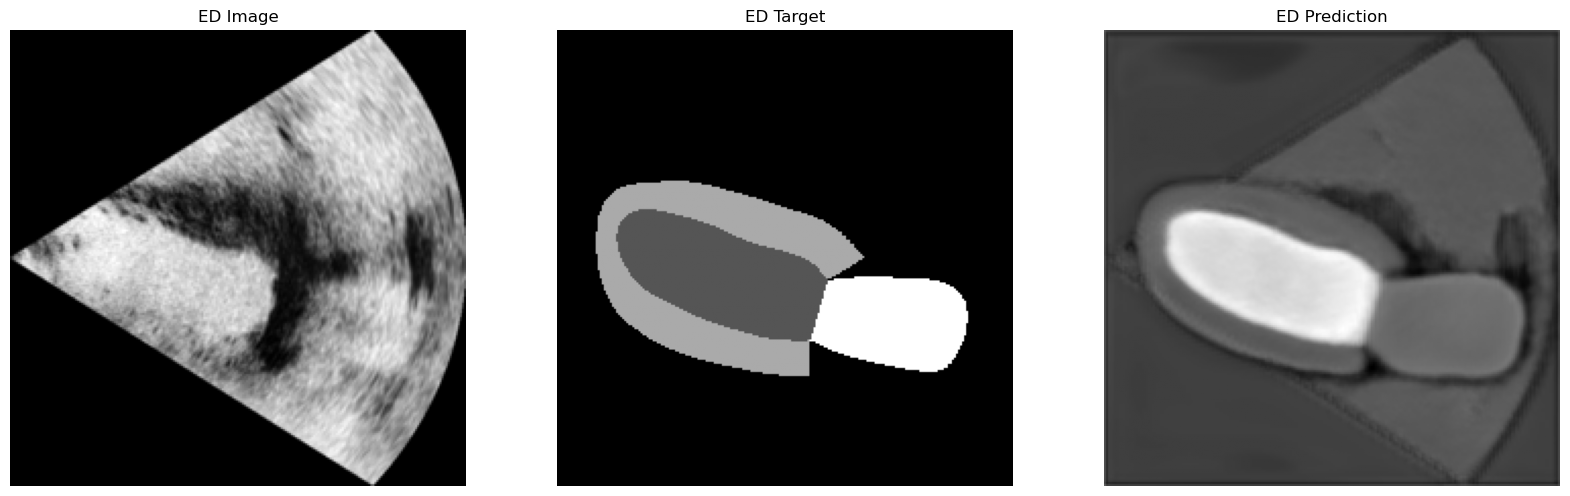

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 30))
axes[0].imshow(ed2_img[0][0], cmap='gray')
axes[0].set_title('ED Image')
axes[0].axis('off')
axes[1].imshow(ed2_seg[0][0], cmap='gray')
axes[1].set_title('ED Target')
axes[1].axis('off')
axes[2].imshow(ed2_pred[0][1], cmap='gray')
axes[2].set_title('ED Prediction')
axes[2].axis('off');

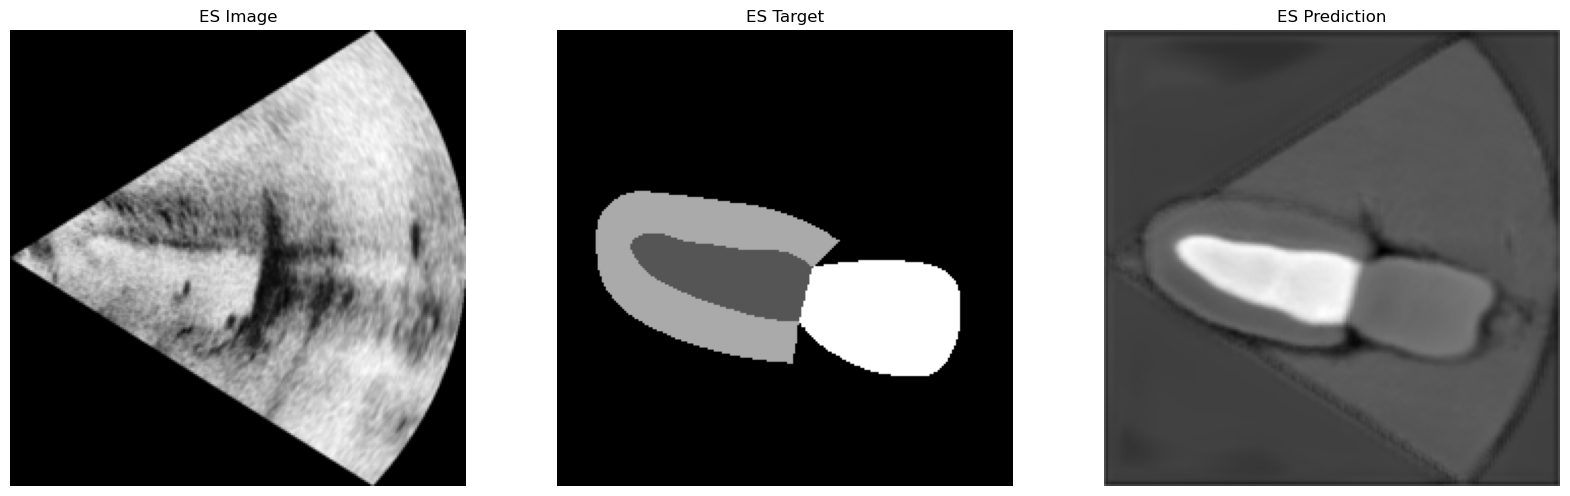

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 30))
axes[0].imshow(es2_img[0][0], cmap='gray')
axes[0].set_title('ES Image')
axes[0].axis('off')
axes[1].imshow(es2_seg[0][0], cmap='gray')
axes[1].set_title('ES Target')
axes[1].axis('off')
axes[2].imshow(es2_pred[0][1], cmap='gray')
axes[2].set_title('ES Prediction')
axes[2].axis('off');

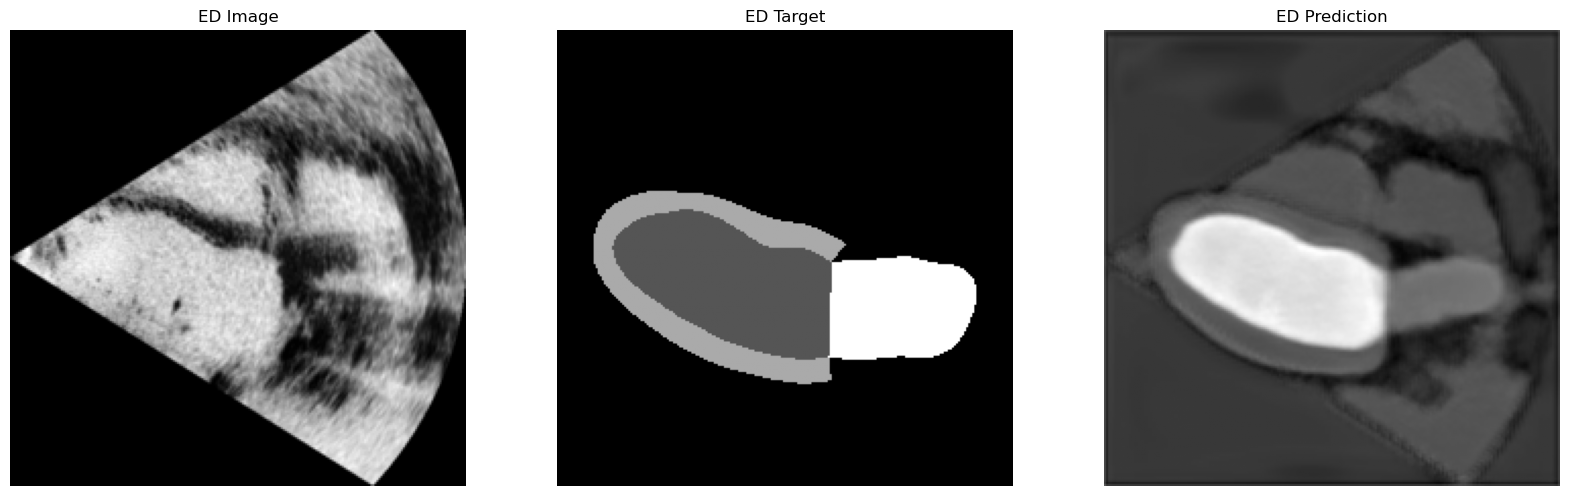

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 30))
axes[0].imshow(ed4_img[0][0], cmap='gray')
axes[0].set_title('ED Image')
axes[0].axis('off')
axes[1].imshow(ed4_seg[0][0], cmap='gray')
axes[1].set_title('ED Target')
axes[1].axis('off')
axes[2].imshow(ed4_pred[0][1], cmap='gray')
axes[2].set_title('ED Prediction')
axes[2].axis('off');

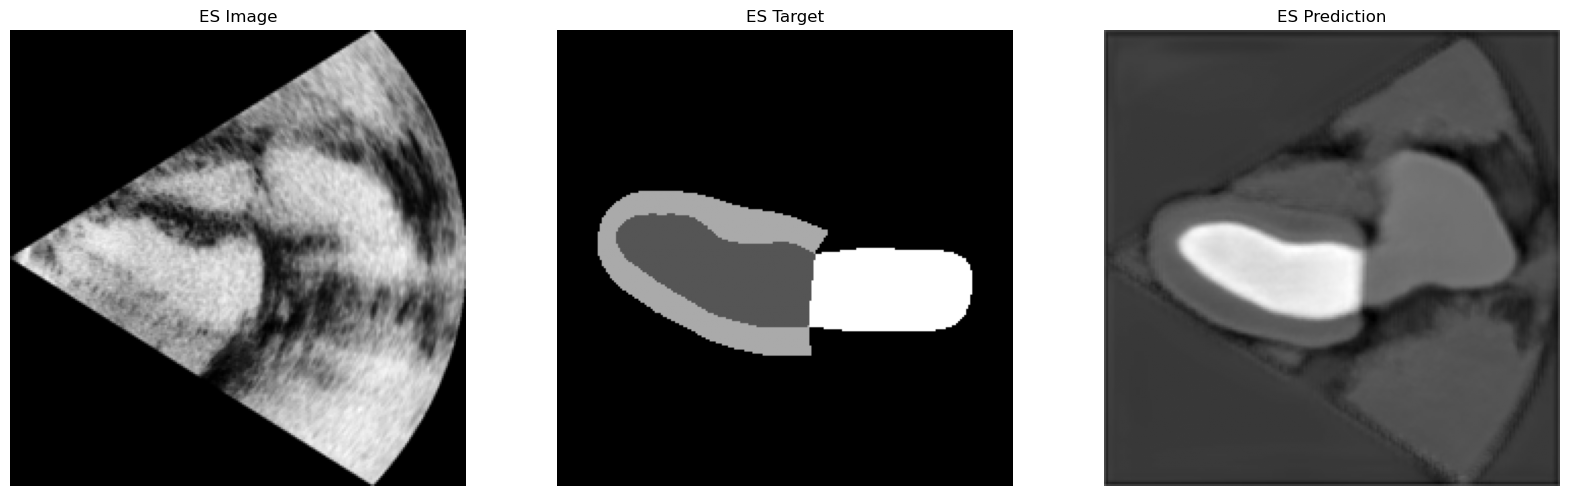

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 30))
axes[0].imshow(es4_img[0][0], cmap='gray')
axes[0].set_title('ES Image')
axes[0].axis('off')
axes[1].imshow(es4_seg[0][0], cmap='gray')
axes[1].set_title('ES Target')
axes[1].axis('off')
axes[2].imshow(es4_pred[0][1], cmap='gray')
axes[2].set_title('ES Prediction')
axes[2].axis('off');

we have to estimate the volume of left ventricular to calculate EF.

In [19]:
def calculate_EF(ed_vol_2CH, es_vol_2CH, ed_vol_4CH, es_vol_4CH):
    
    EDV = (ed_vol_2CH + ed_vol_4CH) / 2
    ESV = (es_vol_2CH + es_vol_4CH) / 2

    EF = ((EDV - ESV) / EDV) * 100
    return EF

In [25]:
def calculate_volume(img_path):
    data = nib.load(img_path).get_fdata()
    data_t = transform(data)
    data_t = data_t.unsqueeze(0)

    with torch.no_grad():
        mask = model(data_t)

    mask = F.interpolate(mask, size=(data.shape[0], data.shape[1]), mode='bilinear', align_corners=False)

    mask = np.array(mask)
    mask = (mask[0, 1, :, :] > 0).astype(np.uint8)  

    pixel_to_mm = 0.308

    x_coords, y_coords = np.where(mask == 1)

    x_min, y_min = np.min(x_coords), y_coords[np.argmin(x_coords)]
    
    x_max, y_max = np.max(x_coords), y_coords[np.argmax(x_coords)]

    L = np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2) * pixel_to_mm

    A_l = np.sum(mask) * (pixel_to_mm ** 2) 

    V = (8 * (A_l ** 2)) / (3 * np.pi * L)

    return V


ed_vol_2CH = calculate_volume("../database_nifti/patient0077/patient0077_2CH_ED.nii.gz")
es_vol_2CH = calculate_volume("../database_nifti/patient0077/patient0077_2CH_ES.nii.gz")
ed_vol_4CH = calculate_volume("../database_nifti/patient0077/patient0077_4CH_ED.nii.gz")
es_vol_4CH = calculate_volume("../database_nifti/patient0077/patient0077_4CH_ES.nii.gz")

ef_value = calculate_EF(ed_vol_2CH, es_vol_2CH, ed_vol_4CH, es_vol_4CH)
print(f"Ejection Fraction (EF) estimated by model: {ef_value:.2f}%")

Ejection Fraction (EF) estimated by model: 49.01%


In [33]:
patients = df_test['Patient'].to_list()
patients_ef = np.array(df_test['EF'].to_list())
pred_ef = []

for patient in patients:
    ed_vol_2CH = calculate_volume(f"../database_nifti/{patient}/{patient}_2CH_ED.nii.gz")
    es_vol_2CH = calculate_volume(f"../database_nifti/{patient}/{patient}_2CH_ES.nii.gz")
    ed_vol_4CH = calculate_volume(f"../database_nifti/{patient}/{patient}_4CH_ED.nii.gz")
    es_vol_4CH = calculate_volume(f"../database_nifti/{patient}/{patient}_4CH_ES.nii.gz")

    pred_ef.append(calculate_EF(ed_vol_2CH, es_vol_2CH, ed_vol_4CH, es_vol_4CH))

pred_ef = np.array(pred_ef)

mae = np.mean(np.abs(pred_ef - patients_ef))
print(f'MAE ---> Mean Absolute Error for test_data: {mae:.2f}')

corr = np.corrcoef(patients_ef, pred_ef)[0, 1]
print(f'Correlation Coefficient for test_data: {corr:.2f}')


MAE ---> Mean Absolute Error for test_data: 6.63
Correlation Coefficient for test_data: 0.69


In [34]:
patients = df_train['Patient'].to_list()
patients_ef = np.array(df_train['EF'].to_list())
pred_ef = []

for patient in patients:
    ed_vol_2CH = calculate_volume(f"../database_nifti/{patient}/{patient}_2CH_ED.nii.gz")
    es_vol_2CH = calculate_volume(f"../database_nifti/{patient}/{patient}_2CH_ES.nii.gz")
    ed_vol_4CH = calculate_volume(f"../database_nifti/{patient}/{patient}_4CH_ED.nii.gz")
    es_vol_4CH = calculate_volume(f"../database_nifti/{patient}/{patient}_4CH_ES.nii.gz")

    pred_ef.append(calculate_EF(ed_vol_2CH, es_vol_2CH, ed_vol_4CH, es_vol_4CH))

pred_ef = np.array(pred_ef)

mae = np.mean(np.abs(pred_ef - patients_ef))
print(f'MAE ---> Mean Absolute Error for train_data: {mae:.2f}')

corr = np.corrcoef(patients_ef, pred_ef)[0, 1]
print(f'Correlation Coefficient for train_data: {corr:.2f}')

MAE ---> Mean Absolute Error for train_data: 6.35
Correlation Coefficient for train_data: 0.78


In [35]:
patients = df_valid['Patient'].to_list()
patients_ef = np.array(df_valid['EF'].to_list())
pred_ef = []

for patient in patients:
    ed_vol_2CH = calculate_volume(f"../database_nifti/{patient}/{patient}_2CH_ED.nii.gz")
    es_vol_2CH = calculate_volume(f"../database_nifti/{patient}/{patient}_2CH_ES.nii.gz")
    ed_vol_4CH = calculate_volume(f"../database_nifti/{patient}/{patient}_4CH_ED.nii.gz")
    es_vol_4CH = calculate_volume(f"../database_nifti/{patient}/{patient}_4CH_ES.nii.gz")

    pred_ef.append(calculate_EF(ed_vol_2CH, es_vol_2CH, ed_vol_4CH, es_vol_4CH))

pred_ef = np.array(pred_ef)

mae = np.mean(np.abs(pred_ef - patients_ef))
print(f'MAE ---> Mean Absolute Error for valid_data: {mae:.2f}')

corr = np.corrcoef(patients_ef, pred_ef)[0, 1]
print(f'Correlation Coefficient for valid_data: {corr:.2f}')

MAE ---> Mean Absolute Error for valid_data: 7.01
Correlation Coefficient for valid_data: 0.82
